In [39]:
# %reset-f
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


This notebook takes the data from the penn tables and complete it with GAR data for small islands when the data is missing

In [40]:
from res_ind_lib import *

from sorted_nicely import *
from replace_with_warning import *

import os, time
import warnings
warnings.filterwarnings("always",category=UserWarning)
from wb_api_wraper import *

In [41]:
import numpy as np
import pandas as pd

#Pandas display options
# pd.set_option('display.max_colwidth', 200)
# pd.set_option('display.width', 200)
# pd.set_option('display.precision', 10)
# pd.set_option('display.max_rows', 500)

#import matplotlib.pylab as plt
import matplotlib.pyplot as plt
%matplotlib inline
font = {'family' : 'serif',
    'weight' : 'normal',
    'size'   : 15}
plt.rc('font', **font)

from fancy_plots import *

In [42]:
#Names to WB names
any_to_wb = pd.read_csv("inputs/any_name_to_wb_name.csv",index_col="any",squeeze=True)

#GAR names with SIDS spec
gar_name_sids = pd.read_csv("inputs/gar_name_sids.csv")

#iso3 to wb country name table
iso3_to_wb=pd.read_csv("inputs/iso3_to_wb_name.csv").set_index("iso3").squeeze()

#iso2 to iso3 table
iso2_iso3 = pd.read_csv("inputs/names_to_iso.csv", usecols=["iso2","iso3"]).drop_duplicates().set_index("iso2").squeeze() #the tables has more lines than countries to account for several ways of writing country names

In [43]:
gar_name_sids['wbcountry'] = gar_name_sids.reset_index().country.replace(any_to_wb)

list_of_sids = gar_name_sids[gar_name_sids.isaSID=="SIDS"].dropna().reset_index().wbcountry

In [44]:
penn = pd.read_excel("inputs/pwt90.xlsx","Data")

In [45]:
penn.columns

Index(['countrycode', 'country', 'currency_unit', 'year', 'rgdpe', 'rgdpo',
       'pop', 'emp', 'avh', 'hc', 'ccon', 'cda', 'cgdpe', 'cgdpo', 'ck',
       'ctfp', 'cwtfp', 'rgdpna', 'rconna', 'rdana', 'rkna', 'rtfpna',
       'rwtfpna', 'labsh', 'delta', 'xr', 'pl_con', 'pl_da', 'pl_gdpo',
       'i_cig', 'i_xm', 'i_xr', 'i_outlier', 'cor_exp', 'statcap', 'csh_c',
       'csh_i', 'csh_g', 'csh_x', 'csh_m', 'csh_r', 'pl_c', 'pl_i', 'pl_g',
       'pl_x', 'pl_m', 'pl_k'],
      dtype='object')

In [46]:
def mrv_gp_2(x):
    """this function gets the most recent value from a dataframe grouped by country"""
    out= x.ix[(x["year"])==np.max(x["year"]),:]
    return out

In [47]:
hop=penn.groupby("country").apply(mrv_gp_2)
hop = hop.drop("country",axis=1).reset_index().drop("level_1",axis=1)

In [48]:
clean_penn = hop[['countrycode', 'country', 'year', 'cgdpo', 'ck']].copy()

In [49]:
clean_penn.head()

,countrycode,country,year,cgdpo,ck
0,ALB,Albania,2014,31419.962891,1.127928e+05
1,DZA,Algeria,2014,497452.875000,1.721824e+06
2,AGO,Angola,2014,205371.265625,7.960541e+05
3,AIA,Anguilla,2014,294.655243,3.296041e+03
4,ATG,Antigua and Barbuda,2014,1363.846924,1.177330e+04


In [50]:
clean_penn["country"] = clean_penn.country.replace(any_to_wb)

In [51]:
GAR = pd.read_csv("inputs/GAR_capital.csv")

In [52]:
GAR["country"] = GAR.country.replace(any_to_wb)

In [53]:
gar_sids = GAR.set_index("country").loc[list_of_sids,:].replace(0, np.nan).dropna()

In [54]:
all_K = pd.concat([gar_sids,clean_penn.set_index("country")],axis=1)

In [55]:
all_K = all_K.loc[(all_K != 0).any(axis=1),:]

In [56]:
all_K.columns

Index(['GDP', 'K', 'GFCF', 'countrycode', 'year', 'cgdpo', 'ck'], dtype='object')

In [57]:
all_K["prod_k_1"] = all_K.GDP/all_K.K
all_K["prod_k_2"] = all_K.cgdpo/all_K.ck

In [73]:
all_K.prod_k_2.describe()

count    180.000000
mean       0.323583
std        0.176928
min        0.018669
25%        0.212377
50%        0.283685
75%        0.386931
max        1.173964
Name: prod_k_2, dtype: float64

In [78]:
all_K[all_K.prod_k_2>0.34]

,GDP,K,GFCF,countrycode,year,cgdpo,ck,prod_k_1,prod_k_2,avg_prod_k,Y,Ktot
Argentina,NaN,NaN,NaN,ARG,2014.0,8.599085e+05,2.148251e+06,NaN,0.400283,0.400283,8.599085e+05,2.148251e+06
Armenia,NaN,NaN,NaN,ARM,2014.0,2.741078e+04,4.400342e+04,NaN,0.622924,0.622924,2.741078e+04,4.400342e+04
Azerbaijan,NaN,NaN,NaN,AZE,2014.0,1.521400e+05,1.386600e+05,NaN,1.097216,1.097216,1.521400e+05,1.386600e+05
Belarus,NaN,NaN,NaN,BLR,2014.0,1.889606e+05,3.389245e+05,NaN,0.557530,0.557530,1.889606e+05,3.389245e+05
Belize,1604.50,5994.0,218.100,BLZ,2014.0,2.736466e+03,5.175436e+03,0.267684,0.528741,0.267684,2.736466e+03,5.175436e+03
Benin,NaN,NaN,NaN,BEN,2014.0,2.228727e+04,6.122473e+04,NaN,0.364024,0.364024,2.228727e+04,6.122473e+04
Bolivia,NaN,NaN,NaN,BOL,2014.0,6.124339e+04,1.210370e+05,NaN,0.505989,0.505989,6.124339e+04,1.210370e+05
Bosnia and Herzegovina,NaN,NaN,NaN,BIH,2014.0,3.827477e+04,1.119245e+05,NaN,0.341970,0.341970,3.827477e+04,1.119245e+05
Bulgaria,NaN,NaN,NaN,BGR,2014.0,1.207547e+05,3.123994e+05,NaN,0.386540,0.386540,1.207547e+05,3.123994e+05
Burkina Faso,NaN,NaN,NaN,BFA,2014.0,2.705625e+04,6.830505e+04,NaN,0.396109,0.396109,2.705625e+04,6.830505e+04


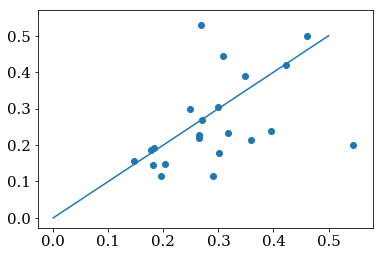

In [58]:
plt.scatter(all_K.prod_k_1,all_K.prod_k_2)
plt.plot([0,0.5],[0,0.5])
#this is just for the small islands.

In [59]:
import statsmodels.formula.api as sm

In [67]:
result = sm.OLS(all_K.dropna().prod_k_1,all_K.dropna().prod_k_2).fit()

In [68]:
result.params.prod_k_2

0.9931837573382043

In [69]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               prod_k_1   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     115.5
Date:                Mon, 26 Jun 2017   Prob (F-statistic):           5.41e-10
Time:                        18:25:06   Log-Likelihood:                 15.211
No. Observations:                  22   AIC:                            -28.42
Df Residuals:                      21   BIC:                            -27.33
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
prod_k_2       0.9932      0.092     10.747      0.000         0.801     1.185
==============================================================================
Omnibus:                        3.877   Durbin-Watson:                   1.391
Prob(Omnibus):                  0.144   Jarque-Bera (JB):                2.369
Skew:                           0.155   Prob(JB):                        0.306
Kurtosis:                       4.577   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [63]:
all_K.loc["Kiribati",:]

GDP             168.95
K                  595
GFCF            64.257
countrycode        NaN
year               NaN
cgdpo              NaN
ck                 NaN
prod_k_1       0.28395
prod_k_2           NaN
Name: Kiribati, dtype: object

In [70]:
all_K["avg_prod_k"] = all_K.prod_k_1
all_K.avg_prod_k = all_K.avg_prod_k.fillna(all_K.prod_k_2)

all_K["Y"] = all_K.cgdpo
all_K.Y = all_K.Y.fillna(all_K.GDP)

all_K["Ktot"] = all_K.ck
all_K.Ktot = all_K.Ktot.fillna(all_K.K)

In [71]:
all_K.sample(3)

,GDP,K,GFCF,countrycode,year,cgdpo,ck,prod_k_1,prod_k_2,avg_prod_k,Y,Ktot
Morocco,NaN,NaN,NaN,MAR,2014.0,245973.343750,1.333799e+06,NaN,0.184416,0.184416,245973.343750,1.333799e+06
Syrian Arab Republic,NaN,NaN,NaN,SYR,2014.0,82747.453125,3.306043e+05,NaN,0.250292,0.250292,82747.453125,3.306043e+05
Kenya,NaN,NaN,NaN,KEN,2014.0,132619.718750,2.905847e+05,NaN,0.456389,0.456389,132619.718750,2.905847e+05


In [72]:
all_K[["avg_prod_k"]].dropna().to_csv("intermediate/avg_prod_k_with_gar_for_sids.csv")

In [77]:
all_K.loc[list_of_sids,"avg_prod_k"].dropna()

Anguilla                          0.089397
Antigua and Barbuda               0.196580
Aruba                             0.290095
Bahamas, The                      0.178144
Bahrain                           0.316784
Barbados                          0.300980
Belize                            0.267684
Bermuda                           0.186163
Virgin Islands, British           0.291212
Cape Verde                        0.264517
Cayman Islands                    0.018669
Comoros                           0.460940
Cuba                              0.390089
Dominica                          0.248925
Dominican Republic                0.299811
Fiji                              0.348104
Grenada                           0.183878
Guinea-Bissau                     0.423189
Guyana                            0.380848
Haiti                             0.133367
Jamaica                           0.203112
Kiribati                          0.283950
Maldives                          0.308994
Mauritius  